In [1]:
# Basic library
import nltk
import logging

import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize.util import align_tokens
from nltk.tokenize.api import TokenizerI
from nltk.tokenize import word_tokenize
from recordlinkage.index import Block
import recordlinkage as rl
import recordlinkage
import jellyfish
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.set_option('display.max_columns', 100)

In [84]:
datasetsDef = ['nac2008.csv', 'nac2009.csv', 'nac2010.csv', 'nac2011.csv', 'nac2012.csv', 'nac2013.csv', 'nac2014.csv', 'nac2015.csv', 
               'nac2016.csv', 'nac2017.csv', 'nac2018.csv', 'nac2019.csv']
anio = '2022'
infoAnios = []
datosMadre = ['Total', 'NOMBRE', 'PATERNO', 'MATERNO', 'CURP_M', 'ENT_RES', 'MPO_RES', 'LOC_RES', 'CALLE_RES', 'FECH_NACM', 'EDOCIVIL', 'NUM_EMB', 
              'NUM_NACMTO', 'ORDEN_NAC', 'SOB_PARTO', 'DERHAB', 'DERHAB2', 'NIV_ESCOL', 'CVEOCUPHAB']
datosMadre2 = ['ENT_NACM', 'MPO_NACM']
datosRecNac = ['FECH_NACH', 'HORA_NACH', 'SEXOH', 'GESTACH', 'TALLAH', 'PESOH', 'PRODUCTO', 'PROCNAC', 'LOC_NAC', 'MPO_NAC', 'ENT_NAC', 'CALLE_NAC',
               'INST_NAC', 'UNIMED', 'ATENDIO']

for dato in datasetsDef:
    bd = pd.read_csv('dgis_datos/nacimiento/faltantes/' + dato, delimiter=',', parse_dates=False, encoding='utf-8')
    bd = bd[datosMadre + datosMadre2 + datosRecNac]
    infoAnios.append(bd)

In [85]:
names = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
datosFaltaList = []
for dato in infoAnios:
    datosFaltaList.append(list(dato.loc[0]))

datosFaltaNAC = pd.DataFrame(datosFaltaList, index=names, columns=datosMadre + datosMadre2 + datosRecNac)
datosFaltaNAC

,Total,NOMBRE,PATERNO,MATERNO,CURP_M,ENT_RES,MPO_RES,LOC_RES,CALLE_RES,FECH_NACM,EDOCIVIL,NUM_EMB,NUM_NACMTO,ORDEN_NAC,SOB_PARTO,DERHAB,DERHAB2,NIV_ESCOL,CVEOCUPHAB,ENT_NACM,MPO_NACM,FECH_NACH,HORA_NACH,SEXOH,GESTACH,TALLAH,PESOH,PRODUCTO,PROCNAC,LOC_NAC,MPO_NAC,ENT_NAC,CALLE_NAC,INST_NAC,UNIMED,ATENDIO
2008,1978380,523,1656,4729,1710030,16134,25042,225459,3,0,36180,4847,76093,12740,18557,0,0,32848,137131,0,0,0,0,3267,20012,7734,4711,13280,5276,15587,184,0,13,415,0,0
2009,2058706,234,1143,3755,1721689,11112,19247,205510,2826,0,34310,3695,64837,10125,12777,62257,50387,9144,137207,1,2,2,2,2524,15990,6686,3881,8836,4513,13217,132,2,2,4,3,1
2010,2073111,205,1166,4147,1581672,9837,16757,177204,1,0,34209,1638,40743,10081,13016,61232,25271,0,97221,0,0,0,0,2778,11599,7775,2927,8227,4086,11344,335,0,0,232,868,0
2011,2167060,156,1026,4288,1498624,8987,14674,158286,10,0,37217,887,31611,12824,9314,65683,74020,41,71185,0,0,0,0,2901,8630,5838,2707,11570,4160,14908,335,1,6,345,21765,0
2012,2071702,118,929,4071,1397061,6771,11582,142272,9,0,32715,734,22133,12677,8042,67492,80289,20,51071,0,30,0,0,2179,6588,4030,2005,8460,2804,16135,327,2,2,367,20659,0
2013,2195074,108,903,4132,1457036,4297,8615,123741,12,2,31019,586,19910,12731,2372,67269,94923,1,29326,1,0,0,0,2286,6218,29004,51136,3306,3039,11920,337,0,1,208,27441,0
2014,2177319,149,1187,4449,1403869,4858,10026,111157,14,2,29328,490,15960,14807,1245,65202,114242,0,26010,0,0,0,0,1877,4770,75685,127926,2665,2969,16711,471,0,1,189,23358,0
2015,2145199,96,1186,4928,1279306,4752,8594,100691,912,0,45988,446,10581,23753,546,60948,626020,0,25199,0,0,0,0,1563,4137,69471,120421,7040,3147,14682,1179,0,27,113,24079,0
2016,2080253,80,1186,5099,1147761,5104,9003,84907,729,0,51379,588,7038,18228,619,46527,867863,0,35623,0,0,0,0,1712,2795,62111,113870,7293,2629,12276,185,0,71,133,28011,0
2017,1994882,58,659,4591,1020525,4421,7660,67221,672,0,46714,409,6814,10165,1081,46149,872634,9776,35065,0,5,0,1,1475,1952,851,616,4383,2340,9676,170,4,39,123,23746,0


Text(0, 0.5, 'N° Nacimientos')

Text(0.5, 1.0, 'Nacimientos por año')

array([1978.38 , 2058.706, 2073.111, 2167.06 , 2071.702, 2195.074,
       2177.319, 2145.199, 2080.253, 1994.882, 1940.656, 1868.214])

[Text(0, 1, '1978k'),
 Text(0, 1, '2058k'),
 Text(0, 1, '2073k'),
 Text(0, 1, '2167k'),
 Text(0, 1, '2071k'),
 Text(0, 1, '2195k'),
 Text(0, 1, '2177k'),
 Text(0, 1, '2145k'),
 Text(0, 1, '2080k'),
 Text(0, 1, '1994k'),
 Text(0, 1, '1940k'),
 Text(0, 1, '1868k')]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2008'),
  Text(1, 0, '2009'),
  Text(2, 0, '2010'),
  Text(3, 0, '2011'),
  Text(4, 0, '2012'),
  Text(5, 0, '2013'),
  Text(6, 0, '2014'),
  Text(7, 0, '2015'),
  Text(8, 0, '2016'),
  Text(9, 0, '2017'),
  Text(10, 0, '2018'),
  Text(11, 0, '2019')])

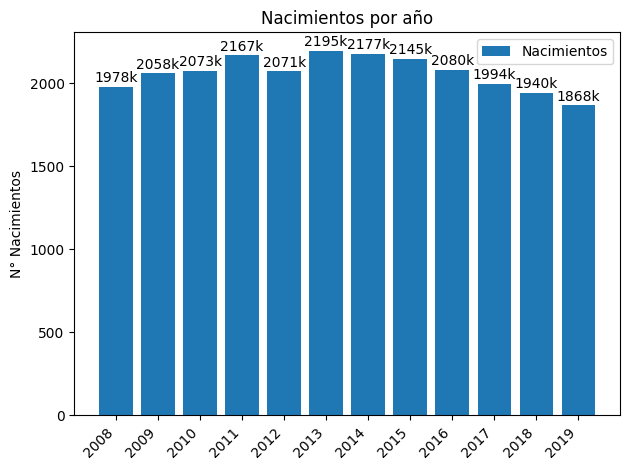

In [86]:
labels = list(datosFaltaNAC.index)
values = [x/1000 for x in list(datosFaltaNAC.Total)]


x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, values, width, label='Nacimientos')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('N° Nacimientos')
ax.set_title('Nacimientos por año')
ax.set_xticks(x, labels)
ax.legend()
rects1.datavalues
ax.bar_label(rects1, fmt='%dk', padding=1)
#ax.bar_label(rects2, padding=3)
plt.xticks(rotation=45, ha="right")
fig.tight_layout()

plt.show()

[24750556,
 2000,
 14727,
 56173,
 15839525,
 85067,
 4,
 468874,
 15284,
 69637,
 2,
 2,
 3,
 25485,
 88377,
 5244,
 28,
 9916]

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '99.77%'),
 Text(0, 1, '36.00%'),
 Text(0, 1, '99.66%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.11%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '99.72%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.90%'),
 Text(0, 1, '99.64%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.96%')]

Text(0, 0.5, 'Total')

Text(0.5, 1.0, 'Datos desconocidos en el periodo 2008-2019')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

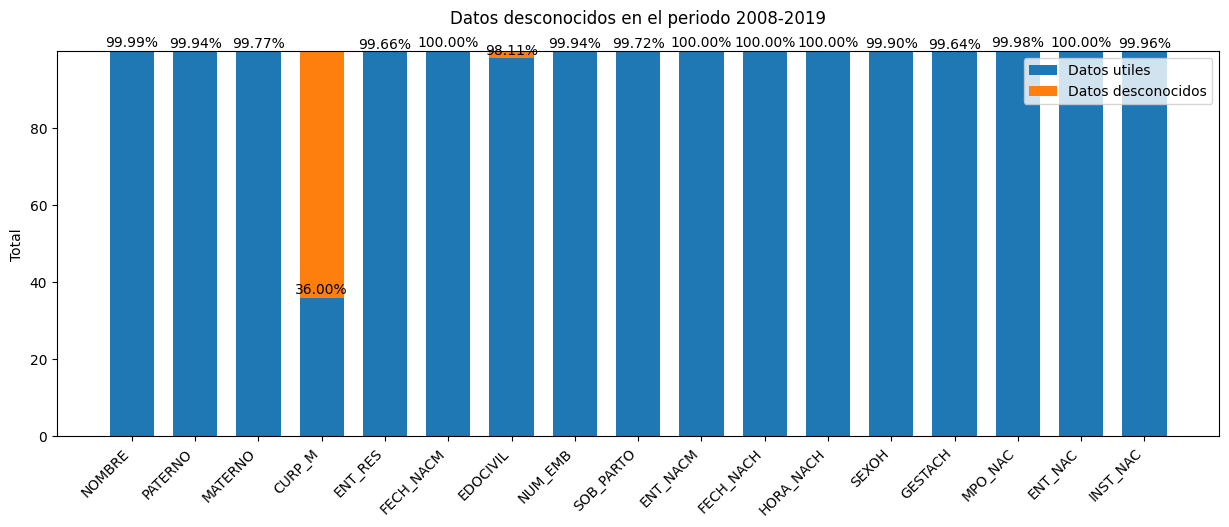

In [102]:
datosMadre = ['Total', 'NOMBRE', 'PATERNO', 'MATERNO', 'CURP_M', 'ENT_RES', 'FECH_NACM', 'EDOCIVIL', 'NUM_EMB', 'SOB_PARTO', 'ENT_NACM']
datosRecNac = ['FECH_NACH', 'HORA_NACH', 'SEXOH', 'GESTACH', 'MPO_NAC', 'ENT_NAC', 'INST_NAC']

porAnio = datosFaltaNAC[datosMadre + datosRecNac]
labels = list(porAnio.columns[1:])
totalFaltantes = list(porAnio.sum())
totalFaltantes
totalDatos = totalFaltantes.pop(0)
width = 0.7

values = [(x/totalDatos)*100 for x in totalFaltantes]
datosUtil = [100 - x for x in values]
##########GRAFICA
fig, ax = plt.subplots()
bar1 = ax.bar(labels, datosUtil, width, label='Datos utiles')
bar2 = ax.bar(labels, values, width, bottom=datosUtil,
        label='Datos desconocidos')

ax.bar_label(bar1, fmt='%.2f%%', padding=1)

ax.set_ylabel('Total')
ax.set_title('Datos desconocidos en el periodo 2008-2019', loc='center', pad=20)
ax.legend()


fig.set_size_inches(15, 5)
plt.xticks(rotation=45, ha="right")

plt.show() 

[Text(0, 1, '99.97%'),
 Text(0, 1, '99.92%'),
 Text(0, 1, '99.76%'),
 Text(0, 1, '13.56%'),
 Text(0, 1, '99.18%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.17%'),
 Text(0, 1, '99.76%'),
 Text(0, 1, '99.06%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.83%'),
 Text(0, 1, '98.99%'),
 Text(0, 1, '99.99%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.98%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2008')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

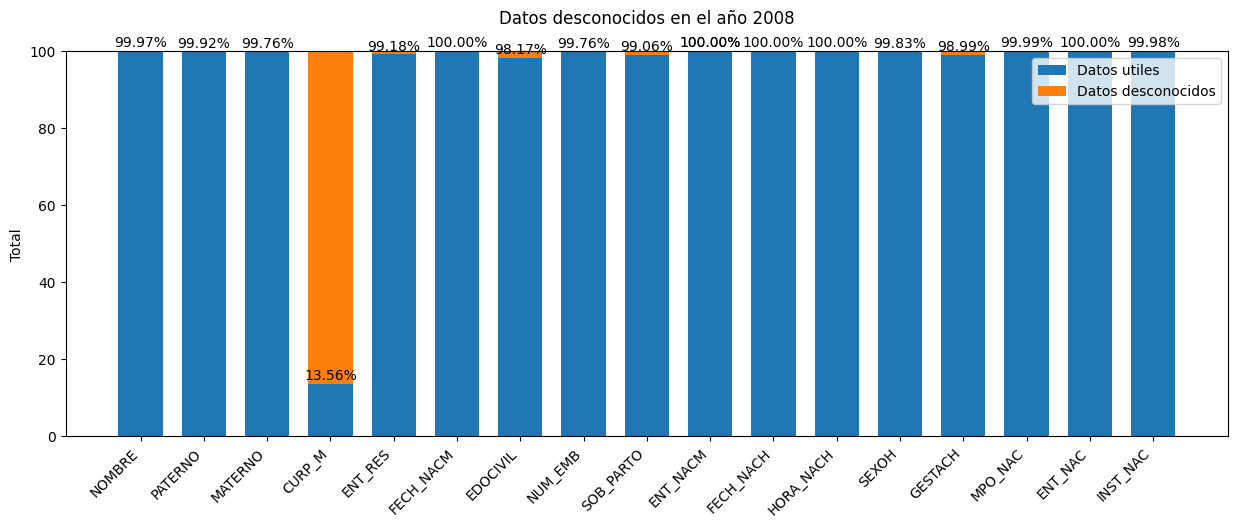

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '99.82%'),
 Text(0, 1, '16.37%'),
 Text(0, 1, '99.46%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.33%'),
 Text(0, 1, '99.82%'),
 Text(0, 1, '99.38%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.88%'),
 Text(0, 1, '99.22%'),
 Text(0, 1, '99.99%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2009')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

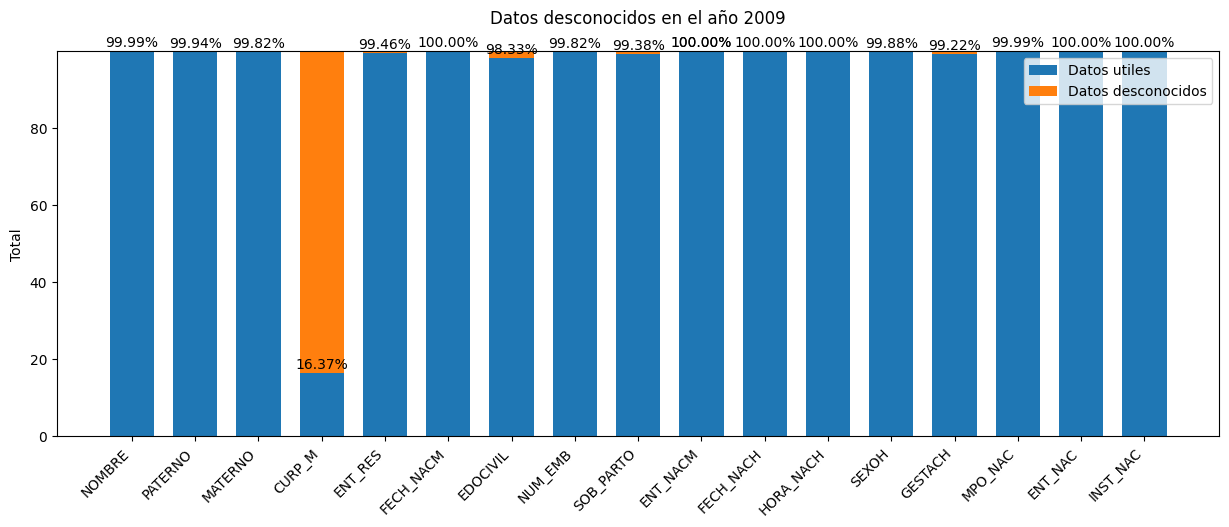

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '99.80%'),
 Text(0, 1, '23.71%'),
 Text(0, 1, '99.53%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.35%'),
 Text(0, 1, '99.92%'),
 Text(0, 1, '99.37%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.87%'),
 Text(0, 1, '99.44%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.99%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2010')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

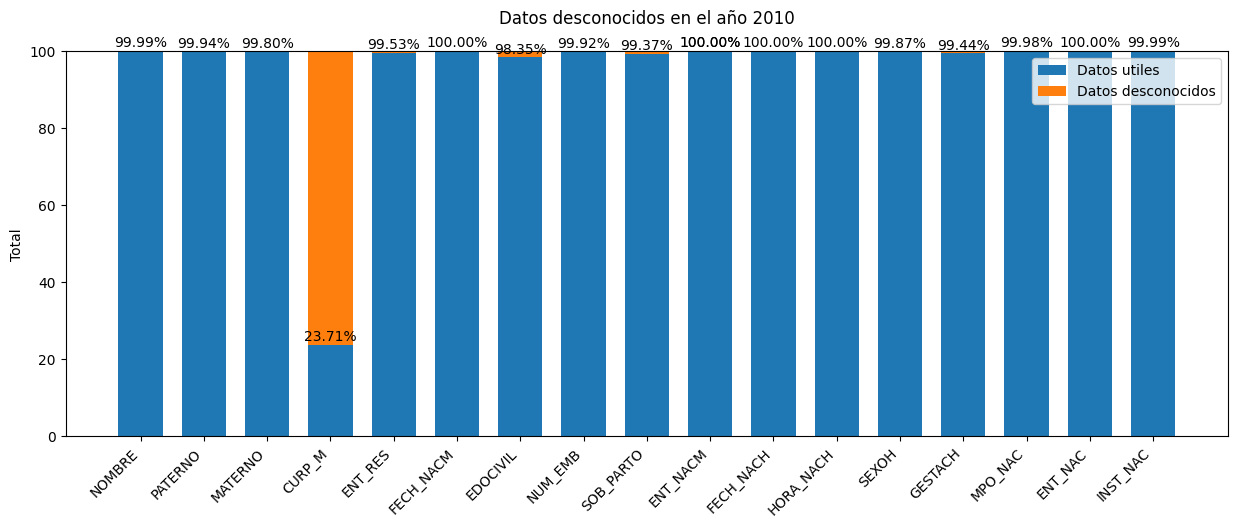

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '99.80%'),
 Text(0, 1, '30.85%'),
 Text(0, 1, '99.59%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.28%'),
 Text(0, 1, '99.96%'),
 Text(0, 1, '99.57%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.87%'),
 Text(0, 1, '99.60%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.98%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2011')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

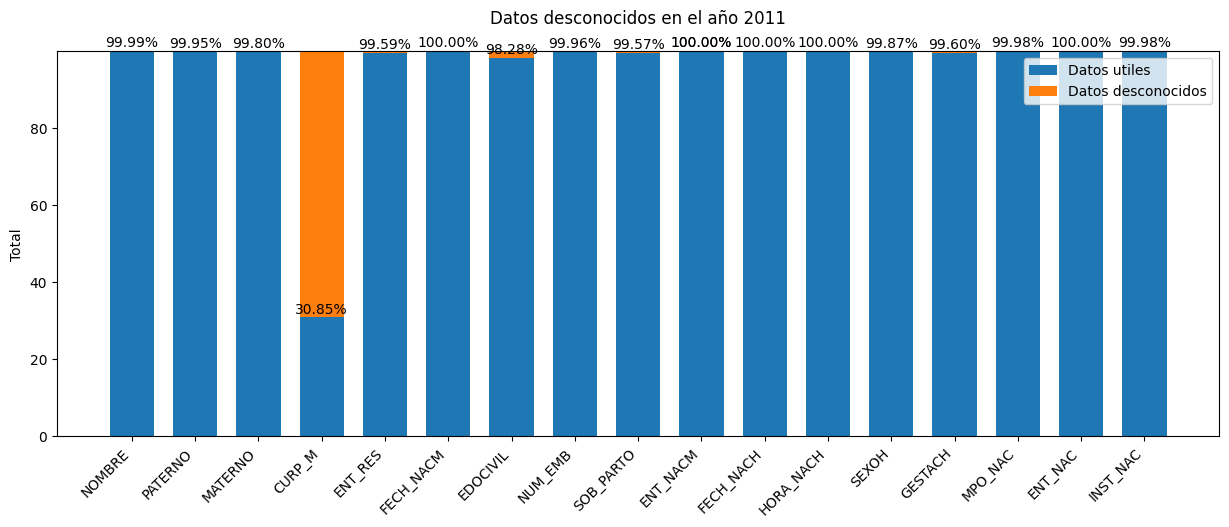

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.96%'),
 Text(0, 1, '99.80%'),
 Text(0, 1, '32.56%'),
 Text(0, 1, '99.67%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.42%'),
 Text(0, 1, '99.96%'),
 Text(0, 1, '99.61%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.89%'),
 Text(0, 1, '99.68%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.98%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2012')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

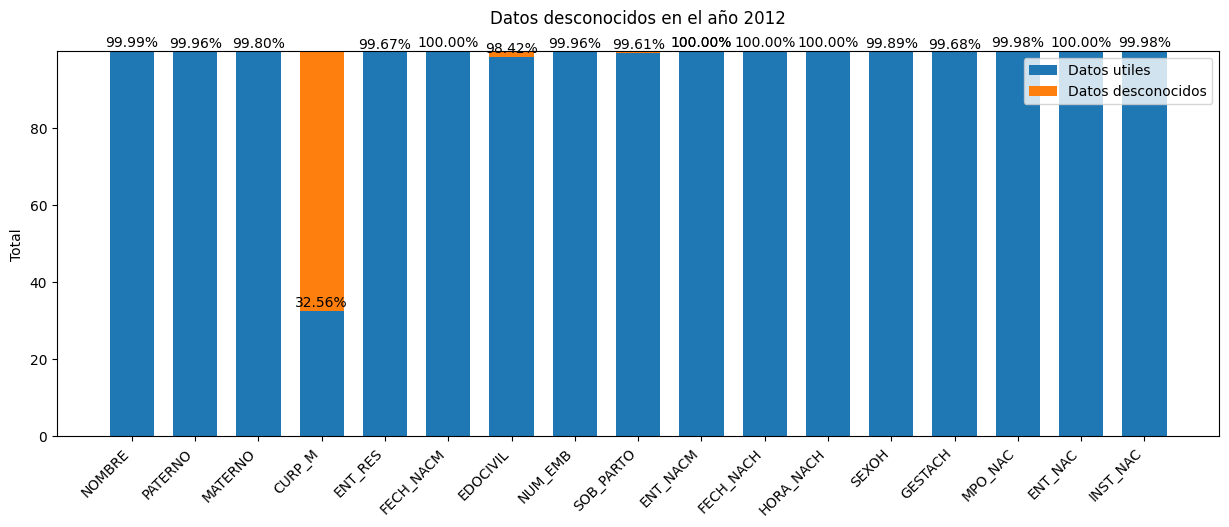

[Text(0, 1, '100.00%'),
 Text(0, 1, '99.96%'),
 Text(0, 1, '99.81%'),
 Text(0, 1, '33.62%'),
 Text(0, 1, '99.80%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.59%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '99.89%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.90%'),
 Text(0, 1, '99.72%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.99%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2013')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

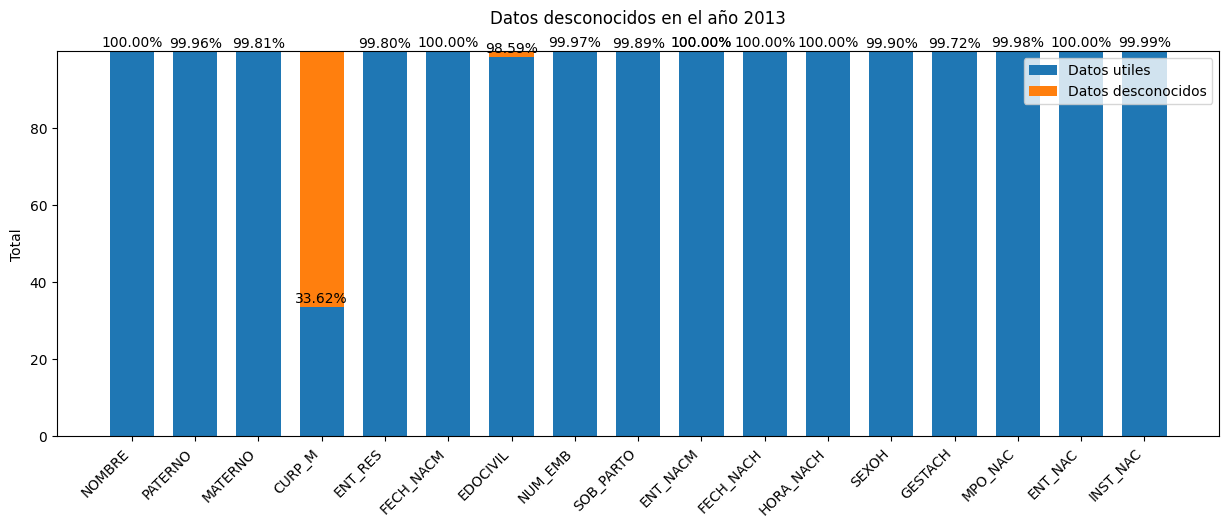

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '99.80%'),
 Text(0, 1, '35.52%'),
 Text(0, 1, '99.78%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '98.65%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.91%'),
 Text(0, 1, '99.78%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.99%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2014')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

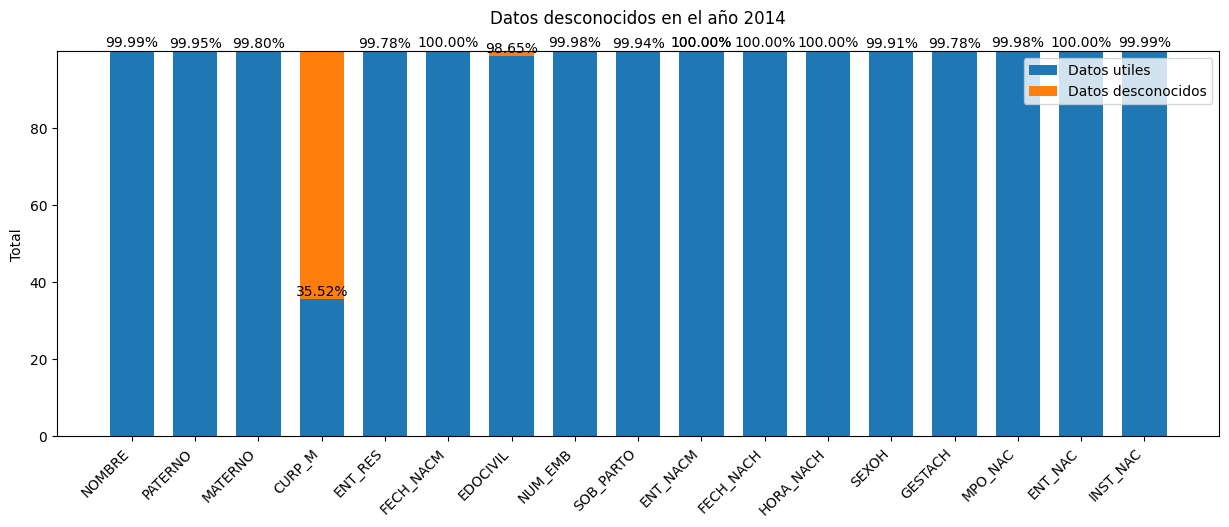

[Text(0, 1, '100.00%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '99.77%'),
 Text(0, 1, '40.36%'),
 Text(0, 1, '99.78%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '97.86%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.93%'),
 Text(0, 1, '99.81%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.99%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2015')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

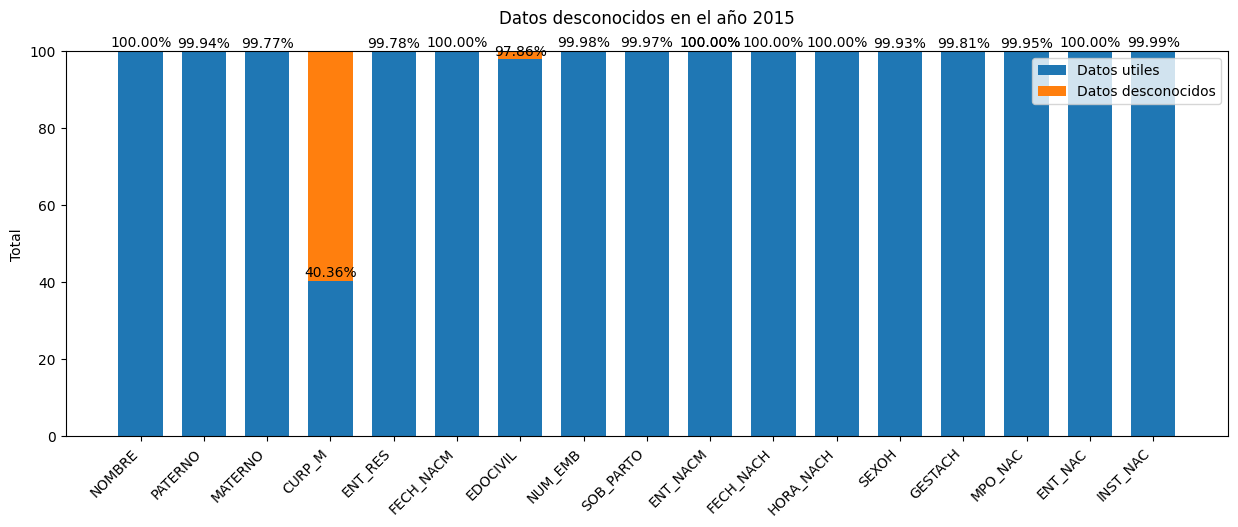

[Text(0, 1, '100.00%'),
 Text(0, 1, '99.94%'),
 Text(0, 1, '99.75%'),
 Text(0, 1, '44.83%'),
 Text(0, 1, '99.75%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '97.53%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.92%'),
 Text(0, 1, '99.87%'),
 Text(0, 1, '99.99%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.99%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2016')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

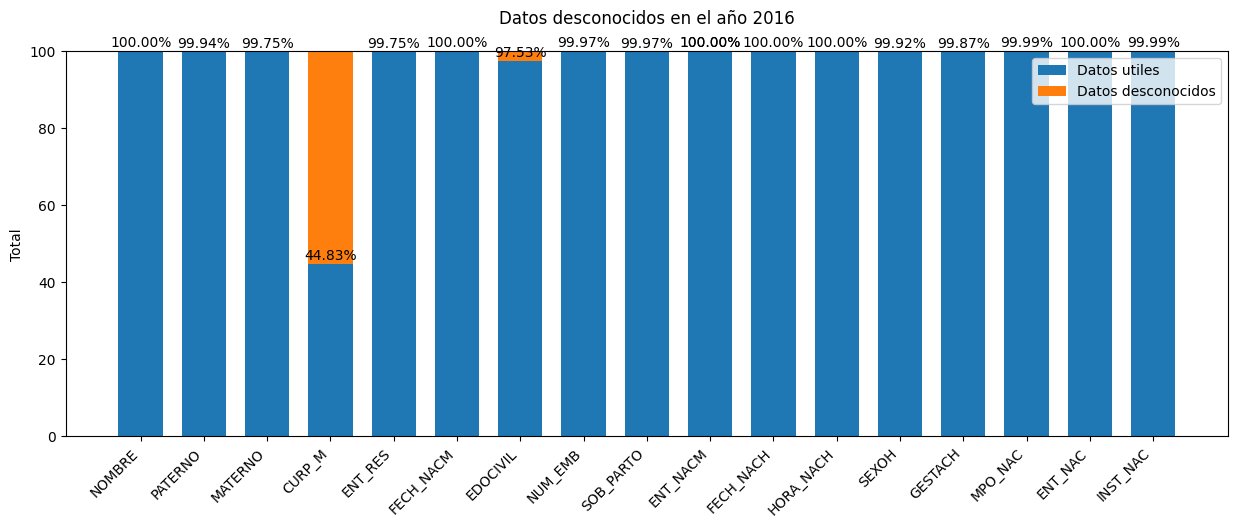

[Text(0, 1, '100.00%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '99.77%'),
 Text(0, 1, '48.84%'),
 Text(0, 1, '99.78%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '97.66%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.93%'),
 Text(0, 1, '99.90%'),
 Text(0, 1, '99.99%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.99%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2017')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

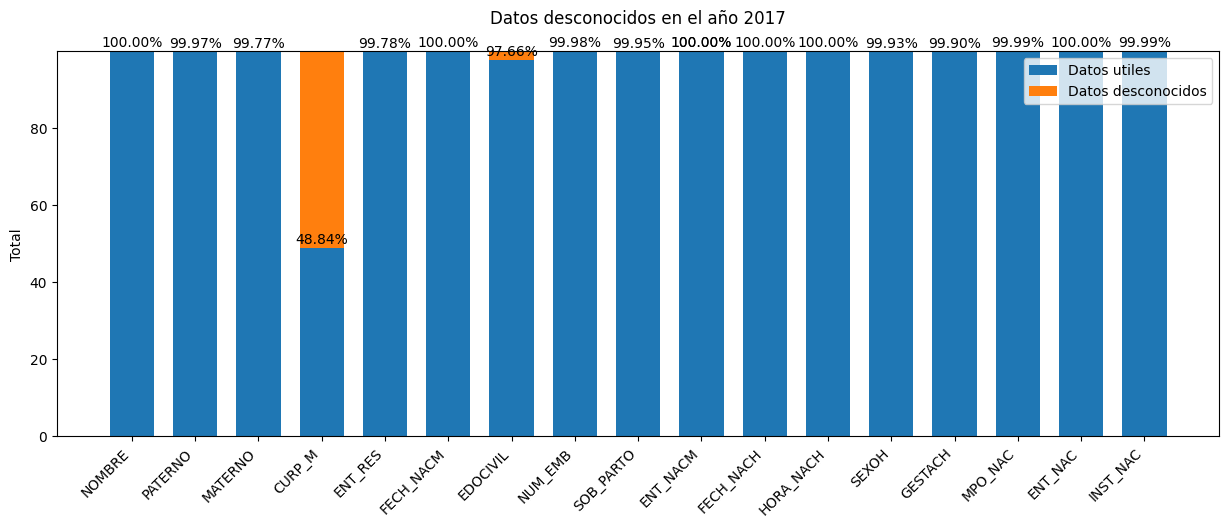

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.84%'),
 Text(0, 1, '99.61%'),
 Text(0, 1, '55.06%'),
 Text(0, 1, '99.75%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '97.60%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.92%'),
 Text(0, 1, '99.85%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.93%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2018')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

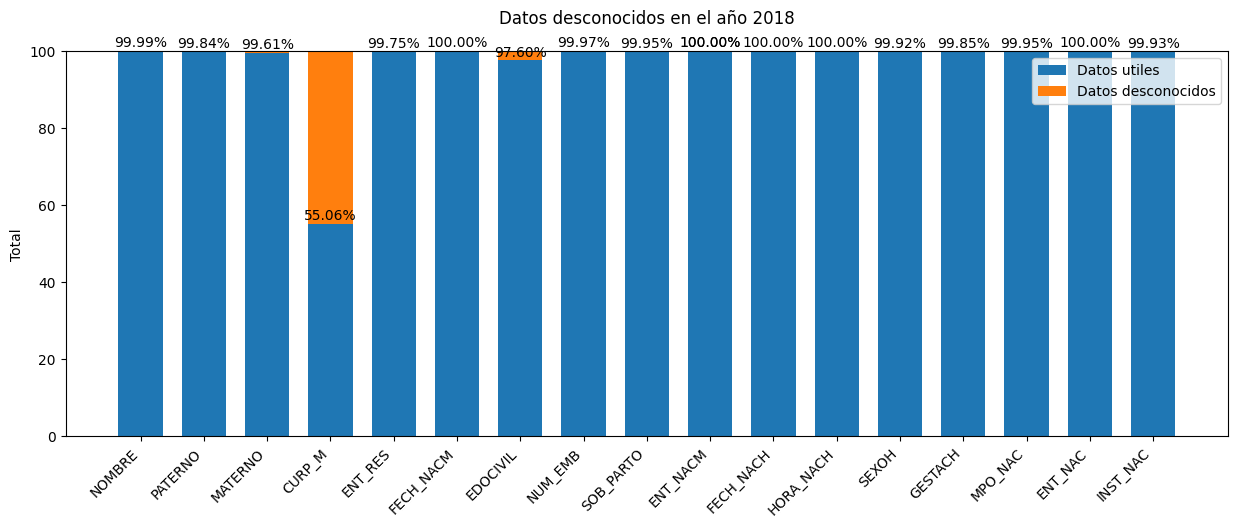

[Text(0, 1, '99.99%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '99.76%'),
 Text(0, 1, '59.86%'),
 Text(0, 1, '99.78%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '97.69%'),
 Text(0, 1, '99.98%'),
 Text(0, 1, '99.95%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.92%'),
 Text(0, 1, '99.85%'),
 Text(0, 1, '99.97%'),
 Text(0, 1, '100.00%'),
 Text(0, 1, '99.66%')]

Text(0.5, 1.0, 'Datos desconocidos en el año 2019')

Text(0, 0.5, 'Total')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

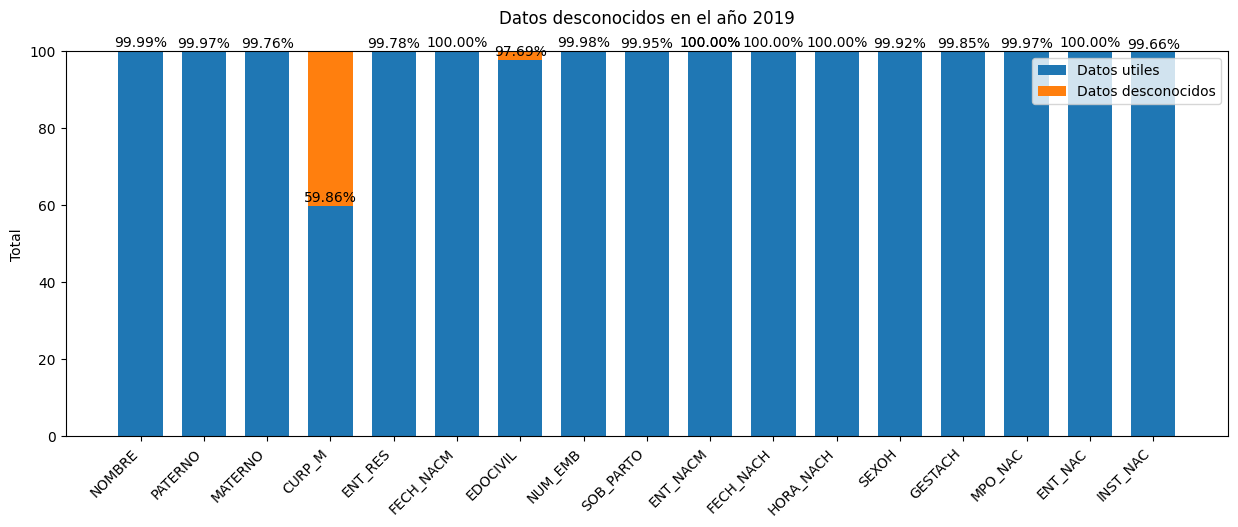

In [29]:
datosMadre = ['NOMBRE', 'PATERNO', 'MATERNO', 'CURP_M', 'ENT_RES', 'FECH_NACM', 'EDOCIVIL', 'NUM_EMB', 'SOB_PARTO', 'ENT_NACM']
datosRecNac = ['FECH_NACH', 'HORA_NACH', 'SEXOH', 'GESTACH', 'MPO_NAC', 'ENT_NAC', 'INST_NAC']

#infoAnios[0]
newCols = datosMadre + datosRecNac

porAnio = datosFaltaNAC[newCols]
labels = list(porAnio.columns)
totales = dict(datosFaltaNAC.Total)
width = 0.7

for anio in names:
       values = [(x/totales[anio])*100 for x in list(porAnio.loc[anio])]
       datosUtil = [100 - x for x in values]
       ##########GRAFICA
       fig, ax = plt.subplots()
       bar1 = ax.bar(labels, datosUtil, width, label='Datos utiles')
       bar2 = ax.bar(labels, values, width, bottom=datosUtil,
              label='Datos desconocidos')
       
       ax.bar_label(bar1, fmt='%.2f%%', padding=1)

       ax.set_title('Datos desconocidos en el año ' + anio, loc='center', pad=20)
       ax.set_ylabel('Total')
       ax.legend()

       
       fig.set_size_inches(15, 5)
       plt.xticks(rotation=45, ha="right")

       plt.show()    

In [2]:
#datasetsNac1 = ['NACIMIENTOS_2008_CIERRE.txt', 'NACIMIENTOS_2009_CIERRE.txt', 
#                'NACIMIENTOS_2010_CIERRE_MITAD1.txt', 'NACIMIENTOS_2010_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2011_CIERRE_MITAD1.txt', 'NACIMIENTOS_2011_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2012_CIERRE_MITAD1.txt', 'NACIMIENTOS_2012_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2013_CIERRE_MITAD1.txt', 'NACIMIENTOS_2013_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2014_CIERRE_MITAD1.txt', 'NACIMIENTOS_2014_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2015_CIERRE_MITAD1.txt', 'NACIMIENTOS_2015_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2016_CIERRE_MITAD1.txt', 'NACIMIENTOS_2016_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2017_CIERRE_MITAD1.txt', 'NACIMIENTOS_2017_CIERRE_MITAD2.txt', 
#                'NACIMIENTOS_2018_CIERRE_MITAD1.txt', 'NACIMIENTOS_2018_CIERRE_MITAD2.txt',
#                'NACIMIENTOS_2019_CIERRE.csv']
#dataFrameNac1 = pd.DataFrame()
#for dato in datasetsNac1:
#    bd = pd.read_csv('dgis_datos/nacimiento/' + dato, delimiter=',', parse_dates=False, encoding='latin1')
#    cols = ['SOB_PARTO', 'SEXOH']
#    residencia = ['ENT_RES','ENT_NAC']
#    bd = bd[cols + residencia]
#    dataFrameNac1 = pd.concat([dataFrameNac1, bd])
    #dataFrameDef1.append(bd)

dataFrameNac1 = pd.read_csv('dgis_datos/nacimiento/nac2008_2019.csv', delimiter=',', parse_dates=False, encoding='latin1')

C:\Users\Hapy_\AppData\Local\Temp\ipykernel_1104\2104283411.py:21: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFrameNac1 = pd.read_csv('dgis_datos/nacimiento/nac2008_2019.csv', delimiter=',', parse_dates=False, encoding='latin1')


([<matplotlib.patches.Wedge at 0x1775334d750>,
 [Text(-0.007918789087472495, -1.0999714963486047, 'Sobrevivencia'),
  Text(0.018121116543871996, 1.2998736958394086, 'Muerte'),
  Text(0.007414910243916562, 1.0999750084006794, 'No especificado')],
 [Text(-0.004319339502257724, -0.5999844525537843, '99.8%'),
  Text(0.011151456334690458, 0.799922274362713, '0.0%'),
  Text(0.004044496496681761, 0.5999863682185523, '0.2%')])

(-1.1005561877482473,
 1.1014475157073131,
 -1.1109576059275614,
 1.3099300404780982)

Text(0.5, 1.0, 'Defunciones de la madre durante el parto 2008-2019')

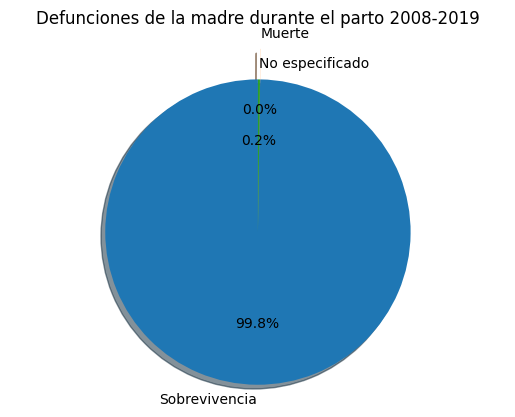

In [90]:
labels = ['Sobrevivencia', 'Muerte', 'No especificado']
sizes = [len(dataFrameNac1[dataFrameNac1.SOB_PARTO == 1]), len(dataFrameNac1[dataFrameNac1.SOB_PARTO == 2]), len(dataFrameNac1[dataFrameNac1.SOB_PARTO == 9])]

sexoLabels = labels.copy()
sexoDatos = sizes.copy()

explode = (0, 0.2, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Defunciones de la madre durante el parto 2008-2019')

plt.show()

([<matplotlib.patches.Wedge at 0x177533f1690>,
 [Text(-1.0995138427407112, -0.032700300022396454, 'Masculino'),
  Text(1.0996136233897233, 0.029152688653434917, 'Femenino'),
  Text(0.004194435853850659, 1.2999932333315694, 'Sin informacion')],
 [Text(-0.5997348233131151, -0.017836527284943518, '50.9%'),
  Text(0.5997892491216672, 0.015901466538237225, '49.0%'),
  Text(0.0025811912946773286, 0.7999958358963503, '0.1%')])

(-1.1040392080761139,
 1.1070270072407171,
 -1.1164945639407626,
 1.3103081743509568)

Text(0.5, 1.0, 'Distribucion de nacimientos segun el sexo 2008-2019')

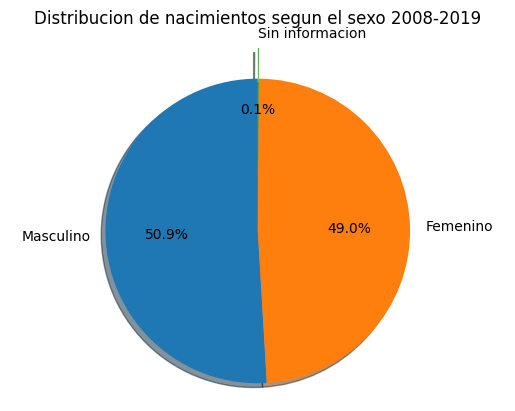

In [92]:
labels = ['Masculino', 'Femenino', 'Sin informacion']
sizes = [len(dataFrameNac1[dataFrameNac1.SEXOH == 1]), len(dataFrameNac1[dataFrameNac1.SEXOH == 2]), len(dataFrameNac1[(dataFrameNac1.SEXOH == 9) | (dataFrameNac1.SEXOH == 9)])]

sexoLabels = labels.copy()
sexoDatos = sizes.copy()

explode = (0, 0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Distribucion de nacimientos segun el sexo 2008-2019')

plt.show()

In [5]:
#dataFrameNac1.to_csv('./dgis_datos/nacimiento/nac2008_2019.csv', header=True, index=False)

Text(0, 0.5, '%° Nacimientos')

Text(0.5, 1.0, 'Nacimientos por entidad 2008-2019')

array([1.37886174e+00, 2.62907230e+00, 5.90314943e-01, 7.21729145e-01,
       2.78190920e+00, 6.52210051e-01, 4.00916570e+00, 2.94273138e+00,
       7.02068128e+00, 1.59497321e+00, 5.71041900e+00, 2.87909553e+00,
       2.38626250e+00, 6.93092188e+00, 1.26408318e+01, 4.13155182e+00,
       1.56797519e+00, 9.17468933e-01, 4.26946098e+00, 3.19233585e+00,
       5.53422568e+00, 1.84416301e+00, 1.28768592e+00, 2.40387937e+00,
       2.50682166e+00, 2.05138600e+00, 2.26803940e+00, 2.90903312e+00,
       1.19942915e+00, 5.82874064e+00, 1.76353433e+00, 1.45477726e+00,
       3.12020973e-04])

[Text(0, 1, '1.4%'),
 Text(0, 1, '2.6%'),
 Text(0, 1, '0.6%'),
 Text(0, 1, '0.7%'),
 Text(0, 1, '2.8%'),
 Text(0, 1, '0.7%'),
 Text(0, 1, '4.0%'),
 Text(0, 1, '2.9%'),
 Text(0, 1, '7.0%'),
 Text(0, 1, '1.6%'),
 Text(0, 1, '5.7%'),
 Text(0, 1, '2.9%'),
 Text(0, 1, '2.4%'),
 Text(0, 1, '6.9%'),
 Text(0, 1, '12.6%'),
 Text(0, 1, '4.1%'),
 Text(0, 1, '1.6%'),
 Text(0, 1, '0.9%'),
 Text(0, 1, '4.3%'),
 Text(0, 1, '3.2%'),
 Text(0, 1, '5.5%'),
 Text(0, 1, '1.8%'),
 Text(0, 1, '1.3%'),
 Text(0, 1, '2.4%'),
 Text(0, 1, '2.5%'),
 Text(0, 1, '2.1%'),
 Text(0, 1, '2.3%'),
 Text(0, 1, '2.9%'),
 Text(0, 1, '1.2%'),
 Text(0, 1, '5.8%'),
 Text(0, 1, '1.8%'),
 Text(0, 1, '1.5%'),
 Text(0, 1, '0.0%')]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Aguascalientes'),
  Text(1, 0, 'Baja California'),
  Text(2, 0, 'Baja California Sur'),
  Text(3, 0, 'Campeche'),
  Text(4, 0, 'Coahuila'),
  Text(5, 0, 'Colima'),
  Text(6, 0, 'Chiapas'),
  Text(7, 0, 'Chihuahua'),
  Text(8, 0, 'Ciudad de Mexico'),
  Text(9, 0, 'Durango'),
  Text(10, 0, 'Guanajuato'),
  Text(11, 0, 'Guerrero'),
  Text(12, 0, 'Hidalgo'),
  Text(13, 0, 'Jalisco'),
  Text(14, 0, 'Estado de Mexico'),
  Text(15, 0, 'Michoacan'),
  Text(16, 0, 'Morelos'),
  Text(17, 0, 'Nayarit'),
  Text(18, 0, 'Nuevo Leon'),
  Text(19, 0, 'Oaxaca'),
  Text(20, 0, 'Puebla'),
  Text(21, 0, 'Queretaro'),
  Text(22, 0, 'Quintana Roo'),
  Text(23, 0, 'San Luis Potosi'),
  Text(24, 0, 'Sinaloa'),
  Text(25, 0, 'Sonora'),
  Text(26, 0, 'Tabasco'),
  Text(27, 0, 'Tamaulipas'),
  Text(28, 0, 'Tlaxcala'),
  Text(29, 0, 'Veracruz'),
  Text

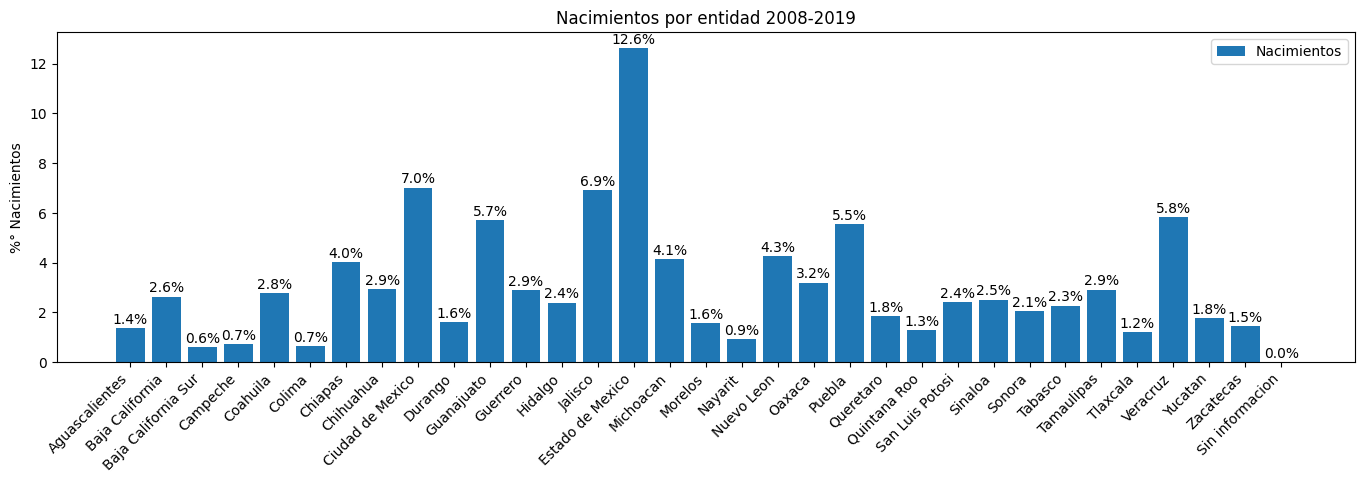

In [94]:
labels = ['Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche', 'Coahuila', 'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de Mexico',
         'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de Mexico', 'Michoacan', 'Morelos', 'Nayarit', 'Nuevo Leon', 'Oaxaca', 
         'Puebla', 'Queretaro', 'Quintana Roo', 'San Luis Potosi', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz', 'Yucatan',
         'Zacatecas', 'Sin informacion']
sizes = [len(dataFrameNac1[dataFrameNac1.ENT_NAC == 1]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 2]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 3]), 
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 4]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 5]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 6]),  
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 7]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 8]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 9]), 
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 10]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 11]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 12]), 
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 13]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 14]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 15]), 
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 16]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 17]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 18]), 
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 19]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 20]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 21]),
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 22]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 23]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 24]),
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 25]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 26]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 27]),
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 28]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 29]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 30]),
        len(dataFrameNac1[dataFrameNac1.ENT_NAC == 31]), len(dataFrameNac1[dataFrameNac1.ENT_NAC == 32]), 
        len(dataFrameNac1[(dataFrameNac1.ENT_NAC == 0) | (dataFrameNac1.ENT_NAC == 88) | (dataFrameNac1.ENT_NAC == 99)])]

totNac = sum(sizes)
sizes = [(x/totNac)*100 for x in sizes]

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, sizes, width, label='Nacimientos')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%° Nacimientos')
ax.set_title('Nacimientos por entidad 2008-2019')
ax.set_xticks(x, labels)
ax.legend()
rects1.datavalues
ax.bar_label(rects1, fmt='%.1f%%', padding=1)
#ax.bar_label(rects2, padding=3)
plt.xticks(rotation=45, ha="right")
fig.tight_layout()
fig.set_size_inches(15, 5)
plt.show()

In [80]:
entMatrix = dataFrameNac1[['ENT_RES', 'ENT_NAC']]
entMatrix = entMatrix.replace(['##'], 99)
entMatrix = entMatrix.replace([np.NAN], 99)
entMatrix = entMatrix.replace(['+', '0', '?2', 'O' ,'n', 'nt', 'v'], 99)
len(dataFrameNac1)


len(entMatrix)
datos1 = set()
entNac = []
for i in list(entMatrix.ENT_NAC):
    i = float(i)
    entNac.append(i)
    datos1.add(i)

#datos1
len(datos1)

datos2 = set()
entRes = []
for i in list(entMatrix.ENT_RES):
    i = float(i)
    entRes.append(i)
    datos2.add(i)

#datos2
len(datos2)

24750556

24750556

34

39

In [81]:
datosNum = pd.DataFrame(entRes, columns=['ENT_RES'])
datosNum['ENT_NAC'] = entNac
datosNum
datosNum = datosNum.replace([0, 33.0, 34.0, 35.0, 36.0, 88.0], 99)

,ENT_RES,ENT_NAC
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
24750551,12.0,12.0
24750552,7.0,7.0
24750553,23.0,23.0
24750554,9.0,9.0


In [104]:

matNac = confusion_matrix(list(datosNum.ENT_RES), list(datosNum.ENT_NAC))
matNac

array([[312391,    146,     11, ...,     16,    864,      0],
       [    18, 636192,    290, ...,      9,     22,      0],
       [    10,    372, 143077, ...,     10,     40,      0],
       ...,
       [     2,      0,      0, ..., 412694,     23,      2],
       [ 10707,      5,      0, ...,     24, 333011,      2],
       [    98,   1054,    196, ...,   1548,    642,     11]], dtype=int64)

array([312391,    146,     11,     25,     79,     38,     72,     70,
          361,     73,    445,     97,     80,    721,    588,     54,
           57,     28,    120,     26,     93,     83,     17,    112,
           67,     65,     23,     47,      7,     81,     16,    864,
            0], dtype=int64)

33

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Entidad de residencia/nacimiento')

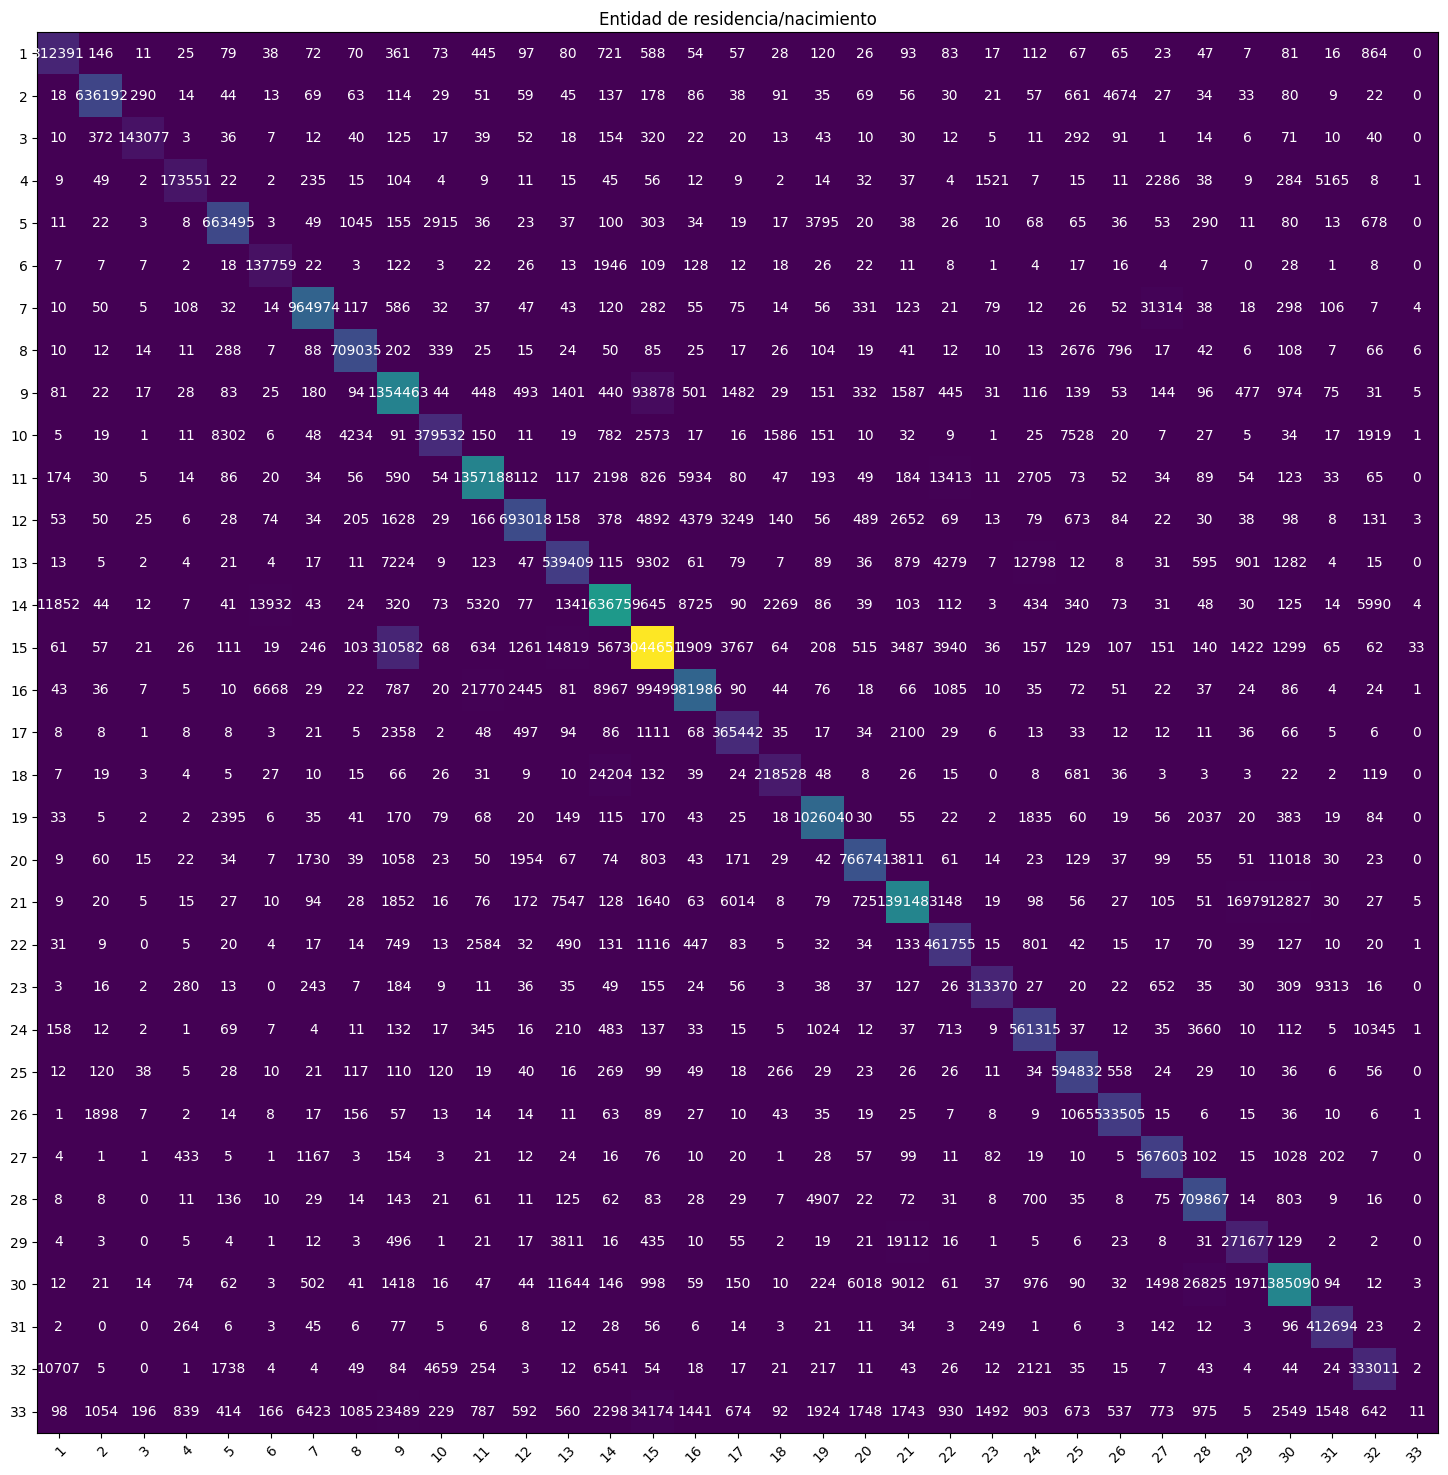

In [105]:
matNac[0]

matrix = np.array(matNac)
labels = [x+1 for x in range(len(matNac))]

vegetables = labels
farmers = labels

harvest = matrix
#harvest = matrix
len(harvest[0])

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(farmers)), labels=farmers)
ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, int(harvest[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Entidad de residencia/nacimiento")
fig.tight_layout()

fig.set_size_inches(17, 17)
plt.show()